In [291]:
import prodigy
import collections
import numpy as np
import pandas as pd
import copy
import random
from prodigy.util import combine_models, split_string, set_hashes
import json

In [216]:
all_dat_dic = get_sets_multi(rounds = ['r1'])

In [342]:
dat_dic = get_sets(['ta_nour_severity_r1'])

In [344]:
dat_dic

{'ta_nour_severity': []}

In [212]:
dat_dic = get_sets(['ta_joe_r4', 'ta_nour_r4', 'ta_jillian_r4'])

In [190]:
all_dat_dic = {'_'.join(k.split('_')[:-1]): [] for k in list(dat_dic.keys())}


In [242]:
def get_sets(input_sets):
    for set_id in input_sets:
        if set_id not in DB:
            print(f"Can't find input dataset '{set_id}' in database")
            return None
    all_examples = {'_'.join(set_id.split('_')[:-1]): DB.get_dataset(set_id) for set_id in input_sets}
    return(all_examples)


def get_sets_multi(prefix = 'ta', annotators = ['joe', 'nour', 'jillian'], rounds = ['1', '2', '3', '4']):
    
    all_dat = []
    
    for i in range(0,len(rounds)):
        input_sets = ['_'.join([prefix, annotators[j], rounds[i]]) for j in range(0, len(annotators))]
        all_dat.append(get_sets(input_sets))
    
    all_dat_dic = {k: [] for k in list(all_dat[0].keys())}
    for k in all_dat_dic.keys():
        for rnd in all_dat:
            all_dat_dic[k] += rnd[k] 
    
    return(all_dat_dic)
        
#     for set_id in input_sets:
#         if set_id not in DB:
#             print(f"Can't find input dataset '{set_id}' in database")
#             return None
#     all_examples = {set_id: DB.get_dataset(set_id) for set_id in input_sets}
#     return(all_examples)



def extract_options(dat):
    dat_i = list(dat.keys())[0]
    options = dat[dat_i][0]['options']
    options_map = {}
    for i in options:
        options_map[i['id']] = i['text']

#     options_map[10] = 'condemnation'
#     options_map[11] = 'not_condemnation'
    
    return(options_map)

def extract_severity_annotations(dat):
    out = collections.defaultdict(lambda:[])
    annotations_by_hash = collections.defaultdict(lambda:[])
    for dat_i in dat.keys():
        for d in dat[dat_i]:

            annotations_d = []

            for option in d['options']:
                if option['id'] != 'hard_to_parse':
                    if option['id'] in d['accept']:
                        annotations_d.append(1)
                    else:
                        annotations_d.append(0)
            
            try:
                rating = annotations_d.index(1) + 1
            except:
                rating = np.NaN 
                
            out[d['_input_hash']].append(rating)
            annotations_by_hash[d['_input_hash']] = d
            
    return(out, annotations_by_hash)

def process_annotations(merged_annotations, options_map, input_sets):
    summed_annotations = collections.defaultdict(lambda:[])
    label_counts = {}

    for o in options_map.items():
        label_counts[o[1]] = {}
        for user in input_sets:
            label_counts[o[1]][user] = 0

    label_counts['nothing'] = {}
    for user in input_sets:
            label_counts['nothing'][user] = 0
            
            
    for d in merged_annotations.items():
        if len(d[1]) == 3:
            annotation_sum = np.sum(d[1],axis=0)

            nothing = []

            for annotation in d[1]:
                if np.sum(annotation[0:4]) == 0:
                    nothing.append([0,1])
                else:
                    nothing.append([1,0])



            for option in options_map.items():
                total_yes = int(annotation_sum[option[0]])
                total_no = int(3 - total_yes)
                summed_annotations[option[1]].append([total_no, total_yes])

                for i,user in enumerate(input_sets):
                    label_counts[option[1]][user] += d[1][i][option[0]]

            # calculate 
            for i,user in enumerate(input_sets):
                label_counts['nothing'][user] += nothing[i][1]

            total_yes = int(np.sum(nothing, axis=0)[1])
            total_no = int(3 - total_yes)

            summed_annotations['nothing'].append([total_no, total_yes])
    return({'summed_annotations': summed_annotations, 'label_counts': label_counts})

In [123]:
list(dat_dic.keys())[0]

'ta_joe_r4'

In [40]:
np.NaN

nan

In [37]:
a = [1,2,3,1]
a.index(1)

0

In [281]:
DB = prodigy.core.connect()


In [289]:
wtf = DB.get_dataset('ta_sanjna_severity_r3')
hashes_in_dataset = DB.get_input_hashes('ta_sanjna_severity_r3')

len(wtf)


70

In [292]:
set_hashes(wtf[0],
overwrite=True,
input_keys=("text", "spans"),
task_keys=("accept"),
ignore=("score", "rank", "answer"),
)

{'text': 'my dad left me at a young age and what -JOHN DOE- done and did is a much bigger betrayal now I gotta get my favourite tattoo covered thaNKS',
 'meta': {'tweet_id': '930208116318330882',
  'mask_map': {'<TARGET 1>': 'Jesse Lacey'},
  'pattern_match': True,
  'target_label': '<TARGET 1>',
  'target': 'Jesse Lacey'},
 'spans': [{'start': 39,
   'end': 49,
   'label': 'TARGET',
   'target': '<TARGET 1>'}],
 'label': 1,
 'accept': [1, '6'],
 '_input_hash': 1874440535,
 '_task_hash': -2136587353,
 'options': [{'id': '1', 'text': '1'},
  {'id': '2', 'text': '2'},
  {'id': '3', 'text': '3'},
  {'id': '4', 'text': '4'},
  {'id': '5', 'text': '5'},
  {'id': '6', 'text': '6'},
  {'id': '7', 'text': '7'},
  {'id': '8', 'text': '8'},
  {'id': '9', 'text': '9'},
  {'id': '0', 'text': '0'},
  {'id': 'hard_to_parse', 'text': 'hard_to_parse'}],
 '_session_id': None,
 '_view_id': 'choice',
 'answer': 'accept'}

In [290]:
wtf[0]

{'text': 'my dad left me at a young age and what -JOHN DOE- done and did is a much bigger betrayal now I gotta get my favourite tattoo covered thaNKS',
 'meta': {'tweet_id': '930208116318330882',
  'mask_map': {'<TARGET 1>': 'Jesse Lacey'},
  'pattern_match': True,
  'target_label': '<TARGET 1>',
  'target': 'Jesse Lacey'},
 'spans': [{'start': 39,
   'end': 49,
   'label': 'TARGET',
   'target': '<TARGET 1>'}],
 'label': 1,
 'accept': [1, '6'],
 '_input_hash': -604059006,
 '_task_hash': -850983762,
 'options': [{'id': '1', 'text': '1'},
  {'id': '2', 'text': '2'},
  {'id': '3', 'text': '3'},
  {'id': '4', 'text': '4'},
  {'id': '5', 'text': '5'},
  {'id': '6', 'text': '6'},
  {'id': '7', 'text': '7'},
  {'id': '8', 'text': '8'},
  {'id': '9', 'text': '9'},
  {'id': '0', 'text': '0'},
  {'id': 'hard_to_parse', 'text': 'hard_to_parse'}],
 '_session_id': None,
 '_view_id': 'choice',
 'answer': 'accept'}

In [274]:
-2138125828 not in hashes_in_dataset

False

In [285]:
len(list(set([i['_input_hash'] for i in wtf])))

100

In [125]:
for i in all_dat_dic['ta_negin_severity']:
    if len(i['accept']) > 2:
        print(i)
        break

{'text': 'Darn it. I was hoping a generation of tech employees would grow up not knowing who -JOHN DOE- was.', 'meta': {'tweet_id': '921475052125614080', 'mask_map': {'<TARGET 1>': 'Robert Scoble'}, 'pattern_match': True, 'target_label': '<TARGET 1>', 'target': 'Robert Scoble'}, 'spans': [{'start': 83, 'end': 93, 'label': 'TARGET', 'target': '<TARGET 1>'}], 'label': 1, 'accept': [1, '3', 'hard_to_parse'], '_input_hash': 1866655364, '_task_hash': -140065915, 'options': [{'id': '1', 'text': '1'}, {'id': '2', 'text': '2'}, {'id': '3', 'text': '3'}, {'id': '4', 'text': '4'}, {'id': '5', 'text': '5'}, {'id': '6', 'text': '6'}, {'id': '7', 'text': '7'}, {'id': '8', 'text': '8'}, {'id': '9', 'text': '9'}, {'id': '0', 'text': '0'}, {'id': 'hard_to_parse', 'text': 'hard_to_parse'}], '_session_id': None, '_view_id': 'choice', 'answer': 'accept'}


In [94]:
options_map

{'1': '1',
 '2': '2',
 '3': '3',
 '4': '4',
 '5': '5',
 '6': '6',
 '7': '7',
 '8': '8',
 '9': '9',
 '0': '0',
 'hard_to_parse': 'hard_to_parse'}

In [212]:
def extract_severity_annotations(dat):
    out = collections.defaultdict(lambda:[])
    annotations_by_hash = collections.defaultdict(lambda:[])
    for dat_i in dat.keys():
        for d in dat[dat_i]:

            annotations_d = []

            for option in d['options']:
                
                if option is not 'hard_to_parse':
                    if option['id'] in d['accept']:
                        annotations_d.append(1)
                    else:
                        annotations_d.append(0)
            

            out[d['_input_hash']].append(annotations_d)
            annotations_by_hash[d['_input_hash']] = d
            
    return(out, annotations_by_hash)

In [ ]:
option is not 'hard_to_parse'

In [211]:
foroptions_map

{'1': '1',
 '2': '2',
 '3': '3',
 '4': '4',
 '5': '5',
 '6': '6',
 '7': '7',
 '8': '8',
 '9': '9',
 '0': '0',
 'hard_to_parse': 'hard_to_parse'}

In [311]:
all_dat_dic = get_sets_multi(annotators= ['negin_severity', 'xiaoyan_severity', 'sanjna_severity'], rounds = ['r3'])
# all_dat_dic = {'ta_negin_severity': all_dat_dic['ta_negin_severity'][0:100], 
#               'ta_sanjna_severity': all_dat_dic['ta_sanjna_severity'][0:100], 
#               'ta_xiaoyan_severity': all_dat_dic['ta_xiaoyan_severity'][0:100]}

#all_dat_dic = get_sets_multi(annotators= ['negin_severity'], rounds = ['r1'])

options_map = extract_options(all_dat_dic)
merged_annotations, annotations_by_hash = extract_annotations(all_dat_dic)
new_merged = {}

for k in merged_annotations.keys():
    if len(merged_annotations[k]) == 3:
        new_merged[k] = merged_annotations[k]

In [241]:
for option in all_dat_dic['ta_negin_severity'][0]['options']:
    if option['id'] != 'hard_to_parse':
        print(option)

[1, 'hard_to_parse']

In [246]:
merged_annotations

defaultdict(<function __main__.extract_annotations.<locals>.<lambda>()>,
            {-83680778: [6, 2, 6],
             402382461: [7, 7, 7],
             1866655364: [3, 3, 4],
             -666308528: [4, 3, 3],
             166633529: [4, 3, 3],
             1437610927: [4, 2],
             1537987715: [4, 2],
             -1566461060: [2, 2, 2],
             -1230152804: [3, 3],
             -10034078: [7, 8],
             167342195: [nan],
             1007777324: [1],
             635256042: [5],
             515205482: [1],
             -791515568: [1],
             -242612679: [5],
             732817870: [6],
             602807640: [1],
             972449420: [6],
             -1098690481: [7],
             -432268891: [1, 1, 2],
             2126124096: [6, 2, 4],
             -147767400: [6, 2, 4],
             -1550360165: [6, 1, 7],
             -761651508: [7, 3, 3],
             -632748339: [6, 2],
             1179261338: [6, 2],
             1269174014: [7, 4],
    

In [182]:
fuck = [i['text'] for i in all_dat_dic['ta_negin_severity']]

In [200]:
wtf = []
with open ('../annotated_data/condemnation_tweets_3_or_less_targets.jsonl', 'r') as f:
    for l in f:
        wtf.append(json.loads(l))

In [201]:
len(wtf)

200

In [308]:
sev_dat = pd.DataFrame({ key:pd.Series(value) for key, value in new_merged.items() }).T
sev_dat.columns = ['Negin', 'Xiaoyan', 'Sanjna']

In [309]:
sev_dat.shape

(134, 3)

In [310]:
sev_dat.corr()

,Negin,Xiaoyan,Sanjna
Negin,1.000000,0.592554,0.581142
Xiaoyan,0.592554,1.000000,0.672502
Sanjna,0.581142,0.672502,1.000000


In [114]:
sev_dat.corr()

,Negin,Xiaoyan,Sanjna
Negin,1.000000,0.592554,0.587007
Xiaoyan,0.592554,1.000000,0.667838
Sanjna,0.587007,0.667838,1.000000


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

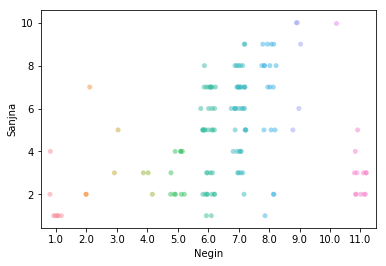

In [174]:
sns.stripplot(x="Negin", y="Sanjna", data=sev_dat, jitter=.25, alpha=.5)

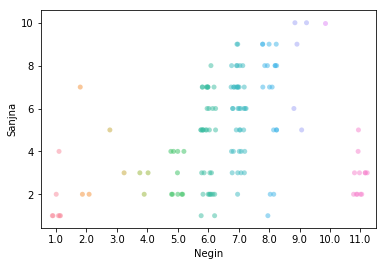

In [85]:
sns.stripplot(x="Negin", y="Sanjna", data=sev_dat, jitter=.25, alpha=.5)

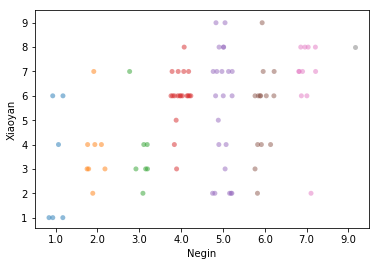

In [255]:
sns.stripplot(x="Negin", y="Xiaoyan", data=sev_dat, jitter=.25, alpha=.5)

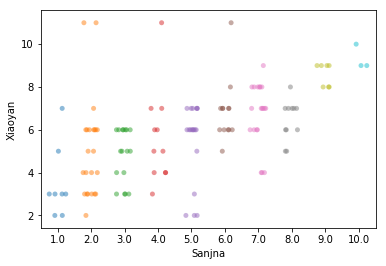

In [87]:
sns.stripplot(x="Sanjna", y="Xiaoyan", data=sev_dat, jitter=.25, alpha=.5)

In [133]:
abs

<function abs(x, /)>

In [300]:
sev_dat['Negin-Sanjna-diff'] = abs(sev_dat.Negin - sev_dat.Sanjna)
sev_dat['Negin-Xiaoyan-diff'] = abs(sev_dat.Negin - sev_dat.Xiaoyan)
sev_dat['Xiaoyan-Sanjna-diff'] = abs(sev_dat.Xiaoyan - sev_dat.Sanjna)

In [301]:
texts = {}
for i in sev_dat.index:
    texts[i] = {}
    texts[i]['text'] = annotations_by_hash[i]['text']

sev_texts = pd.DataFrame.from_dict(texts).T


In [303]:
sev_dat.columns

Index(['Negin', 'Xiaoyan', 'Sanjna', 'Negin-Sanjna-diff', 'Negin-Xiaoyan-diff',
       'Xiaoyan-Sanjna-diff', 'rowwise_std'],
      dtype='object')

In [304]:
sev_dat['rowwise_std'] = sev_dat[['Negin', 'Xiaoyan', 'Sanjna']].std(1)

In [305]:
sev_dat = sev_dat.join(sev_texts)

In [261]:
sev_dat.sort_values('rowwise_std', ascending=False)

,Negin,Xiaoyan,Sanjna,Negin-Sanjna-diff,Negin-Xiaoyan-diff,Xiaoyan-Sanjna-diff,rowwise_std,text
708160449,6.0,2.0,8.0,2.0,4.0,6.0,3.055050,-JOHN DOE- Got inspired by G.O.T Joffrey Barat...
-2137930674,1.0,6.0,6.0,5.0,5.0,0.0,2.886751,.@NPR has been very upfront in its handling of...
-499318503,7.0,2.0,6.0,1.0,5.0,4.0,2.645751,-JOHN DOE- is former Gawker. Wonder what the w...
-1745671005,2.0,7.0,3.0,1.0,5.0,4.0,2.645751,Why did you think Keith Ellison would be less ...
26226402,4.0,8.0,9.0,5.0,4.0,1.0,2.645751,threw up and took an hr-long shower after read...
997670002,1.0,6.0,2.0,1.0,5.0,4.0,2.645751,"Google ""-JOHN DOE-"" you will be amazed at what..."
275493381,5.0,9.0,10.0,5.0,4.0,1.0,2.645751,How about a -JOHN DOE- severed head photo for ...
2117209600,5.0,5.0,1.0,4.0,0.0,4.0,2.309401,What's with all these Hollywood dudes being ca...
1953941146,6.0,7.0,3.0,3.0,1.0,4.0,2.081666,"Yeah, because we aren't about to elect -JOHN D..."
-565592021,5.0,2.0,6.0,1.0,3.0,4.0,2.081666,Waiting to see if the right wing defenders acc...


In [306]:
sev_dat.sort_values('rowwise_std', ascending=False).to_csv('./ta_severity_annotators_data_r3.csv')

In [30]:
((sev_dat.Jillian - sev_dat.Nour) ** 2).mean() ** .5

1.5082470488303112

In [31]:
((sev_dat.Jillian - sev_dat.Joe) ** 2).mean() ** .5

2.7065112695188467

In [32]:
((sev_dat.Joe - sev_dat.Nour) ** 2).mean() ** .5

2.0222341343941714

In [67]:
sds = sev_dat[['Joe', 'Jillian', 'Nour']].std()
means = sev_dat[['Joe', 'Jillian', 'Nour']].mean()
median = sev_dat[['Joe', 'Jillian', 'Nour']].median()

pd.DataFrame([means, median, sds], index=['Mean', 'Median', 'SD']).T

,Mean,Median,SD
Joe,4.170732,4.0,2.198014
Jillian,6.268657,7.0,1.699908
Nour,5.287770,5.0,1.699295


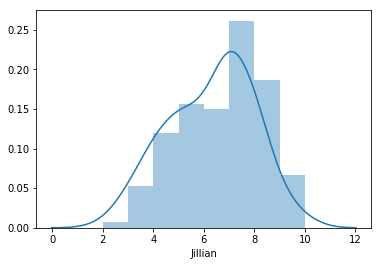

In [74]:
sns.distplot(sev_dat['Jillian'])

In [266]:
DB = prodigy.core.connect()
#input_sets = ['ta_joe_r4', 'ta_nour_r4', 'ta_jillian_r4']
all_dat_dic = get_sets_multi(annotators= ['joe_severity', 'nour_severity', 'jillian_severity'], rounds = ['r2', 'r3', 'r4'])
options_map = extract_options(all_dat_dic)
merged_annotations, annotations_by_hash = extract_annotations(all_dat_dic)
input_sets = all_dat_dic.keys()
processed_annotations = process_annotations(merged_annotations, options_map, input_sets)

In [311]:
def get_majority_vote(merged_annotations, annotations_by_hash, options_map):
    maj_vote_dat = []
    for v in merged_annotations.items():
        if len(v[1]) > 2:
            
            n_con = np.array(v[1])[:,10].sum()
            #n_con = np.array(v[1])[:,options_map['not_condemnation']].sum()
            
            label = 1 if n_con > len(v[1])/2 else 0

            an = {'text': annotations_by_hash[v[0]]['text'],
             'meta': annotations_by_hash[v[0]]['meta'],
             'spans': annotations_by_hash[v[0]]['spans'],
             'label': label, 
             'accept': [label]}
            
            
            an = prodigy.util.set_hashes(
                an,
                overwrite=True,
                input_keys=("text", "spans"),
                task_keys=("accept"),
                ignore=("score", "rank", "answer"),
            )
            
            maj_vote_dat.append(an)
    
    return(maj_vote_dat)
            
            

In [ ]:
all_dat_dic['ta_joe'][0]

In [312]:
maj_vote_dat = get_majority_vote(merged_annotations, annotations_by_hash, options_map)

In [ ]:
with open('../absa_dev/out_test.jsonl', 'a') as f:
            for answer in answers:
                if answer['answer'] is 'accept':
                    lab = 1
                else:
                    lab = 0
                f.write(answer['absa_text'] + '\n' + answer['target'] + '\n' + str(lab) + '\n')

In [320]:
maj_vote_dat_copy = copy.deepcopy(maj_vote_dat)
random.shuffle(maj_vote_dat_copy)


In [321]:
len(maj_vote_dat_copy)

946

In [322]:
maj_vote_dat_copy[0]

{'text': 'And <OTHER TARGET 3>, <OTHER TARGET 7>, <OTHER TARGET 4>, <OTHER TARGET 5>, Segal, <OTHER TARGET 14>, -JOHN DOE-, <OTHER TARGET 8>, Keppner, <OTHER TARGET 13>, <OTHER TARGET 6>, <OTHER TARGET 12>, Price, <OTHER TARGET 2>, Fish, Weiseltier, Oresles, <OTHER TARGET 10>, Blackwell, <OTHER TARGET 1>, Webster, <OTHER TARGET 9> and the many we won’t hear about @Redpainter1 @JeanConnell9',
 'meta': {'tweet_id': '929067989986660354',
  'mask_map': {'<TARGET 1>': 'Knight Landesman',
   '<TARGET 2>': 'Mark Halperin',
   '<TARGET 3>': 'Harvey Weinstein',
   '<TARGET 4>': 'Kevin Spacey',
   '<TARGET 5>': 'Brett Ratner',
   '<TARGET 6>': 'James Toback',
   '<TARGET 7>': 'Jeremy Piven',
   '<TARGET 8>': 'Matthew Weiner',
   '<TARGET 9>': 'John Besh',
   '<TARGET 10>': 'Jann Wenner',
   '<TARGET 11>': 'Dustin Hoffman',
   '<TARGET 12>': 'Chris Savino',
   '<TARGET 13>': 'Jeffrey Tambor',
   '<TARGET 14>': 'Ed Westwick'},
  'pattern_match': True,
  'target_label': '<TARGET 11>',
  'target': '

In [323]:
c = 0
nc = 0

for i in range(0,100):
    if maj_vote_dat_copy[i]['label'] == 1:
        c +=1
    else:
        nc += 1
print(c)
print(nc)

81
19


In [332]:
def format_instance(d):
    start = d['spans'][0]['start']
    end = d['spans'][0]['end']
    if start != 0:
        if end != len(d['text']):
            text = d['text'][0:start-1] + ' $' + d['text'][start:end] + '$ ' + d['text'][end+1:]
        else:
            text = d['text'][0:start-1] + ' $' + d['text'][start:end] + '$'
    else:
        if end != len(d['text']):
            text = '$' + d['text'][start:end] + '$ ' + d['text'][end+1:]
        else:
            text = '$' + d['text'][start:end] + '$'
    return(text)
    

In [337]:
format_instance(maj_vote_dat_copy[1])

'All the Trumpers banging on about $-JOHN DOE-$  who voted for -JOHN DOE- for President? No one. Who voted for Trump for President? You did.'

In [339]:
condemnation = []
p = '/joe/home/research/transgression_ambiguity/annotation_code/review/condemnation_tweets.txt'
with open(p, 'w') as f:
    for i in range(0,100):
        if maj_vote_dat_copy[i]['label'] == 1:
            f.write(format_instance(maj_vote_dat_copy[i]) + '\n')

        
        

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/joe/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-339-7fe3021f67cf>", line 3, in <module>
    with open(p, 'w') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/joe/home/research/transgression_ambiguity/annotation_code/review/condemnation_tweets.txt'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/joe/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2034, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/joe/.local/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1151, in get_records
    return _

FileNotFoundError: [Errno 2] No such file or directory: '/joe/home/research/transgression_ambiguity/annotation_code/review/condemnation_tweets.txt'

In [326]:

with open('../../../ABSA-PyTorch/datasets/transgression_ambiguity/train_round_1_condemnation.absa', 'w') as f:
    for eg in maj_vote_dat_copy[100:]:
        f.write(eg['text'].replace('-JOHN DOE-', '$T$') + '\n' + '-JOHN DOE-' + '\n' + str(eg['label']) + '\n')
        
        
with open('../../../ABSA-PyTorch/datasets/transgression_ambiguity/test_round_1_condemnation.absa', 'w') as f:
    for eg in maj_vote_dat_copy[0:100]:
        f.write(eg['text'].replace('-JOHN DOE-', '$T$') + '\n' + '-JOHN DOE-' + '\n' + str(eg['label']) + '\n')

In [293]:
DB.add_dataset('ta_maj_vote_copy')

<Dataset: 712>

In [328]:
DB.drop_dataset('ta_maj_vote')

True

In [329]:
DB.add_examples(maj_vote_dat_copy, ['ta_maj_vote'])

In [288]:
help(DB.add_examples)

Help on method add_examples in module prodigy.components.db:

add_examples(examples, datasets=()) method of prodigy.components.db.Database instance
    examples (list): The examples to add.
    datasets (list): The names of the dataset(s) to add the examples to.



In [284]:
eg = maj_vote_dat[0]
text = eg['text']

print(eg['text'].replace('-JOHN DOE-', '$T$') + '\n' + '-JOHN DOE-' + '\n' + str(eg['label']) + '\n')

Colorado's House Speaker (D) Crisanta Duran removes Rep. $T$ from a position following a report of sexual harrassment
-JOHN DOE-
0



In [281]:
maj_vote_dat[0]

{'text': "Colorado's House Speaker (D) Crisanta Duran removes Rep. -JOHN DOE- from a position following a report of sexual harrassment",
 'meta': {'tweet_id': '929067246214885376',
  'mask_map': {'<TARGET 1>': 'Steve Lebsock'},
  'pattern_match': True,
  'target_label': '<TARGET 1>',
  'target': 'Steve Lebsock'},
 'spans': [{'start': 57,
   'end': 67,
   'label': 'TARGET',
   'target': '<TARGET 1>'}],
 'label': 0}

In [243]:
options_map

{0: 'allegation',
 1: 'explicit condemnation',
 2: 'implicit condemnation',
 3: 'explicit defense',
 4: 'implicit defense',
 5: 'probabilistic_reasoning',
 6: 'hard_to_parse',
 7: 'hard_to_categorize',
 8: 'technical_problem',
 9: 'not_about_metoo',
 10: 'condemnation',
 11: 'not_condemnation'}

In [261]:
np.array(merged_annotations[1405411699])[:,1].sum()

0

In [242]:
annotations_by_hash[1405411699]

{'text': 'SX, Durval, DS, R21, Lenis, Neris, Rodrigo, Osvaldo, Wesley, -JOHN DOE-, Mena, Marquinhos...',
 'meta': {'tweet_id': '923796887144157184',
  'mask_map': {'<TARGET 1>': 'Raul Bocanegra'},
  'target_label': '<TARGET 1>',
  'target': 'Raul Bocanegra'},
 'options': [{'id': 0, 'text': 'allegation'},
  {'id': 1, 'text': 'explicit condemnation'},
  {'id': 2, 'text': 'implicit condemnation'},
  {'id': 3, 'text': 'explicit defense'},
  {'id': 4, 'text': 'implicit defense'},
  {'id': 5, 'text': 'probabilistic_reasoning'},
  {'id': 6, 'text': 'hard_to_parse'},
  {'id': 7, 'text': 'hard_to_categorize'},
  {'id': 8, 'text': 'technical_problem'},
  {'id': 9, 'text': 'not_about_metoo'}],
 'spans': [{'start': 61,
   'end': 71,
   'label': 'TARGET',
   'target': '<TARGET 1>'}],
 '_input_hash': 1405411699,
 '_task_hash': 552247154,
 '_session_id': None,
 '_view_id': 'choice',
 'accept': [9],
 'answer': 'accept'}

In [236]:
options_map

{0: 'allegation',
 1: 'explicit condemnation',
 2: 'implicit condemnation',
 3: 'explicit defense',
 4: 'implicit defense',
 5: 'probabilistic_reasoning',
 6: 'hard_to_parse',
 7: 'hard_to_categorize',
 8: 'technical_problem',
 9: 'not_about_metoo',
 10: 'condemnation',
 11: 'not_condemnation'}

In [225]:
for k in processed_annotations['summed_annotations'].keys():
    print(f'\n\n---{k}---')
    print(processed_annotations['label_counts'][k])
    fleissKappa(processed_annotations['summed_annotations'][k],n=3)



---allegation---
{'ta_joe': 52, 'ta_nour': 49, 'ta_jillian': 43}
#raters =  3 , #subjects =  942 , #categories =  2
PA =  0.9794762915782028
PE = 0.9032820804089416
Fleiss' Kappa = 0.788


---explicit condemnation---
{'ta_joe': 223, 'ta_nour': 276, 'ta_jillian': 274}
#raters =  3 , #subjects =  942 , #categories =  2
PA =  0.9115357395612192
PE = 0.6025759690749481
Fleiss' Kappa = 0.777


---implicit condemnation---
{'ta_joe': 529, 'ta_nour': 483, 'ta_jillian': 450}
#raters =  3 , #subjects =  942 , #categories =  2
PA =  0.8372257607926427
PE = 0.5006012814984107
Fleiss' Kappa = 0.674


---explicit defense---
{'ta_joe': 13, 'ta_nour': 9, 'ta_jillian': 13}
#raters =  3 , #subjects =  942 , #categories =  2
PA =  0.9900920028308564
PE = 0.9755367833518402
Fleiss' Kappa = 0.595


---implicit defense---
{'ta_joe': 18, 'ta_nour': 14, 'ta_jillian': 16}
#raters =  3 , #subjects =  942 , #categories =  2
PA =  0.9794762915782033
PE = 0.966606713817554
Fleiss' Kappa = 0.385


---probabilisti

In [147]:
dat_dic = get_sets(input_sets)

In [148]:
dat_i = 'ta_joe_r4'
user = 'joe'

In [149]:
out = collections.defaultdict(lambda: [])

for d in dat_dic[dat_i]:
    out['user'].append(user)
    out['_input_hash'].append(d['_input_hash'])
    
    for option in d['options']:
        if option['id'] in d['accept']:
            out[option['text']].append(1)
        else:
            out[option['text']].append(0)        

In [150]:
options = dat_dic['ta_joe_r4'][0]['options']
options_map = {}
for i in options:
    options_map[i['id']] = i['text']
    
options_map[10] = 'condemnation'

In [117]:
options_map

{0: 'allegation',
 1: 'explicit condemnation',
 2: 'implicit condemnation',
 3: 'explicit defense',
 4: 'implicit defense',
 5: 'probabilistic_reasoning',
 6: 'hard_to_parse',
 7: 'hard_to_categorize',
 8: 'technical_problem',
 9: 'not_about_metoo',
 10: 'condemnation'}

In [151]:
out = collections.defaultdict(lambda:[])
for dat_i in dat_dic.keys():
    for d in dat_dic[dat_i]:
        
        annotations_d = []

        for option in d['options']:
            if option['id'] in d['accept']:
                annotations_d.append(1)
            else:
                annotations_d.append(0)
        
        if annotations_d[1] == 1 or annotations_d[2] == 1:
            annotations_d.append(1)
        else:
            annotations_d.append(0)
                
        out[d['_input_hash']].append(annotations_d)



In [152]:
summed_annotations = collections.defaultdict(lambda:[])
label_counts = {}

for o in options_map.items():
    label_counts[o[1]] = {}
    for user in input_sets:
        label_counts[o[1]][user] = 0

label_counts['nothing'] = {}
for user in input_sets:
        label_counts['nothing'][user] = 0


In [153]:
for d in out.items():
    if len(d[1]) == 3:
        annotation_sum = np.sum(d[1],axis=0)
        
        nothing = []
        
        for annotation in d[1]:
            if np.sum(annotation[0:4]) == 0:
                nothing.append([0,1])
            else:
                nothing.append([1,0])
        
        
        
        for option in options_map.items():
            total_yes = int(annotation_sum[option[0]])
            total_no = int(3 - total_yes)
            summed_annotations[option[1]].append([total_no, total_yes])
            
            for i,user in enumerate(input_sets):
                label_counts[option[1]][user] += d[1][i][option[0]]
        
        # calculate 
        for i,user in enumerate(input_sets):
            label_counts['nothing'][user] += nothing[i][1]
                
        total_yes = int(np.sum(nothing, axis=0)[1])
        total_no = int(3 - total_yes)
        
        summed_annotations['nothing'].append([total_no, total_yes])


In [93]:
options_map

{0: 'allegation',
 1: 'explicit condemnation',
 2: 'implicit condemnation',
 3: 'explicit defense',
 4: 'implicit defense',
 5: 'probabilistic_reasoning',
 6: 'hard_to_parse',
 7: 'hard_to_categorize',
 8: 'technical_problem',
 9: 'not_about_metoo'}

In [154]:
for k in summed_annotations.keys():
    print(f'\n\n---{k}---')
    print(label_counts[k])
    fleissKappa(summed_annotations[k],n=3)



---allegation---
{'ta_joe_r4': 31, 'ta_nour_r4': 38, 'ta_jillian_r4': 28}
#raters =  3 , #subjects =  486 , #categories =  2
PA =  0.9739368998628256
PE = 0.8757933618219143
Fleiss' Kappa = 0.79


---explicit condemnation---
{'ta_joe_r4': 106, 'ta_nour_r4': 134, 'ta_jillian_r4': 130}
#raters =  3 , #subjects =  486 , #categories =  2
PA =  0.9163237311385447
PE = 0.6212561695465724
Fleiss' Kappa = 0.779


---implicit condemnation---
{'ta_joe_r4': 264, 'ta_nour_r4': 241, 'ta_jillian_r4': 213}
#raters =  3 , #subjects =  486 , #categories =  2
PA =  0.8079561042524
PE = 0.5001138414236012
Fleiss' Kappa = 0.616


---explicit defense---
{'ta_joe_r4': 4, 'ta_nour_r4': 4, 'ta_jillian_r4': 5}
#raters =  3 , #subjects =  486 , #categories =  2
PA =  0.9931412894375855
PE = 0.9823263541954796
Fleiss' Kappa = 0.612


---implicit defense---
{'ta_joe_r4': 12, 'ta_nour_r4': 6, 'ta_jillian_r4': 11}
#raters =  3 , #subjects =  486 , #categories =  2
PA =  0.9711934156378595
PE = 0.9610107236739356


In [31]:
test = pd.DataFrame.from_dict(out)

In [18]:
len(summed_annotations['allegation'])

92

In [43]:
np.sum(out[1437610927], axis=0)

array([0, 0, 3, 0, 0, 0, 1, 0])

In [62]:
explicit_condemnation = []
for d in out.items():
    if len(d[1]) == 3:
        annotation_sum = np.sum(d,axis=0)
        explicit_condemnation.append([explicit_condemnation[1]])



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/joe/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-62-fe3e6a8ac8b4>", line 4, in <module>
    annotation_sum = np.sum(d,axis=0)
  File "<__array_function__ internals>", line 6, in sum
  File "/home/joe/prodigy_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 2229, in sum
    initial=initial, where=where)
  File "/home/joe/prodigy_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 90, in _wrapreduction
    return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
TypeError: unsupported operand type(s) for +: 'int' and 'list'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/joe/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2034, in showtraceback
    stb = value._render_traceback_()
AttributeEr

TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [65]:
d['options']

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/joe/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-65-02988520b1e3>", line 1, in <module>
    d['options']
TypeError: tuple indices must be integers or slices, not str

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/joe/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2034, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/joe/.local/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1151, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/joe/.local/lib/python3.6/sit

TypeError: tuple indices must be integers or slices, not str

In [9]:
def checkInput(rate, n):
    """ 
    Check correctness of the input matrix
    @param rate - ratings matrix
    @return n - number of raters
    @throws AssertionError 
    """
    N = len(rate)
    k = len(rate[0])
    assert all(len(rate[i]) == k for i in range(k)), "Row length != #categories)"
    assert all(isinstance(rate[i][j], int) for i in range(N) for j in range(k)), "Element not integer" 
    assert all(sum(row) == n for row in rate), "Sum of ratings != #raters)"

def fleissKappa(rate,n):
    """ 
    Computes the Kappa value
    @param rate - ratings matrix containing number of ratings for each subject per category 
    [size - N X k where N = #subjects and k = #categories]
    @param n - number of raters   
    @return fleiss' kappa
    """

    N = len(rate)
    k = len(rate[0])
    print("#raters = ", n, ", #subjects = ", N, ", #categories = ", k)
    checkInput(rate, n)

    #mean of the extent to which raters agree for the ith subject 
    PA = sum([(sum([i**2 for i in row])- n) / (n * (n - 1)) for row in rate])/N
    print("PA = ", PA)
    
    # mean of squares of proportion of all assignments which were to jth category
    PE = sum([j**2 for j in [sum([rows[i] for rows in rate])/(N*n) for i in range(k)]])
    print("PE =", PE)
    
    kappa = -float("inf")
    try:
        kappa = (PA - PE) / (1 - PE)
        kappa = float("{:.3f}".format(kappa))
    except ZeroDivisionError:
        print("Expected agreement = 1")

    print("Fleiss' Kappa =", kappa)
    
    return kappa

In [32]:
test.head()

,_input_hash,allegation,confusing,explicit condemnation,explicit defense,hard,implicit condemnation,implicit defense,irrelevant,user
0,1437610927,0,0,0,0,0,1,0,0,joe
1,1537987715,0,0,0,0,0,1,0,0,joe
2,-1230152804,0,0,0,0,0,1,0,0,joe
3,-10034078,0,0,1,0,0,0,0,0,joe
4,-1071463078,1,0,0,0,0,0,0,0,joe


Two files: ingest and agreement

agreement gives you a class for loading data. ingest2.py gives you how I use the annotation class. The inputs are 

python ingest2.py --files <raw_annotation_file.tsv> ...

gives you Fleiss and PABAK fleiss

idk what format you have, but, good luck!!!

In [34]:
hd = pd.read_csv('Hate_5.tsv', sep='\t')

In [35]:
hd

,Dataset,Tweet ID,Username,Foundation,Comment,Abstract Issue,Issue Start,Issue End,Issue,Text
0,Gab3,197863,christianjleong,"nh,nm",NaN,NaN,-1,-1,NaN,Are Preppers Terrorists ? https://www.youtube....
1,Gab3,197865,christianjleong,"nh,fairness",NaN,NaN,-1,-1,NaN,Danie returns and explains why South Africans ...
2,Gab3,197867,christianjleong,"nh,care",NaN,NaN,-1,-1,NaN,Nedbank advises those who have loans will stil...
3,Gab3,213630,christianjleong,"nh,nm",NaN,NaN,-1,-1,NaN,President Trump Says Three Tech Titans Are in ...
4,Gab3,213631,christianjleong,"nh,nm",NaN,NaN,-1,-1,NaN,The Permeation of Propaganda in the College St...
5,Gab3,213632,christianjleong,"nh,nm",NaN,NaN,-1,-1,NaN,"Sarah Palin, Loyal Running Mate, Excluded from..."
6,Gab3,213633,christianjleong,"nh,nm",NaN,NaN,-1,-1,NaN,Here's Why Ditching Facebook Is Becoming a Thi...
7,Gab3,213634,christianjleong,"nh,fairness",NaN,NaN,-1,-1,NaN,Did Sarah Palin really deserve that? | America...
8,Gab3,235150,christianjleong,"nh,nm",NaN,NaN,-1,-1,NaN,Cribs – Introducing the WW2 set and our produc...
9,Gab3,235151,christianjleong,"nh,nm",NaN,NaN,-1,-1,NaN,The legal tangle around the Trans-Mountain pip...
